The Biggest weakness in the competitive analysis was (the 2.6% comparability) and then you solve it with a more sophisticated data science technique. We will solve this issue

The Goal: Move the exact name matching to cononical product matching. We want to group "Coca-Cola 500ml", "Coke Classic 500ml Bottle", and "Coca-Cola Original Taste 0.5L" into a single canonical product: "coca-cola-500ml". This will massively expand our comparable product universe.

## e5-large transformer to Create Canonical Products

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import process, fuzz
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_processing import normalise_product_name

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
INTERIM_PATH = "C:/Project/UK store analysis/data/01_interim/cleaned_supermarket_data.parquet"
df_comp = pd.read_parquet(INTERIM_PATH)

print("Cleaned data loaded successfully")
df_comp.head(3)

Cleaned data loaded successfully


,supermarket,prices,prices_unit,unit,names,date,category,own_brand
0,Aldi,3.09,0.14,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 22 Pack/...,2024-04-13,baby_products,False
1,Aldi,3.09,0.17,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 18 Pack/...,2024-04-13,baby_products,False
2,Aldi,3.59,0.09,unit,Mamia Ultra-fit Nappy Pants 40 Pack/Size 4,2024-04-13,baby_products,False


In [6]:
df_comp['normalized_name'] = df_comp['names'].apply(normalise_product_name)

# Check a few results
df_comp[['names', 'normalized_name']].head(10)


,names,normalized_name
0,Mamia Ultra-fit Peppa Pig Nappy Pants 22 Pack/...,mamia ultrafit peppa pig nappy pants size 6
1,Mamia Ultra-fit Peppa Pig Nappy Pants 18 Pack/...,mamia ultrafit peppa pig nappy pants size 7
2,Mamia Ultra-fit Nappy Pants 40 Pack/Size 4,mamia ultrafit nappy pants size 4
3,Mamia Boy's Night Pants 15 Pack,mamia boys night pants
4,Mamia Girl's Night Pants 15 Pack,mamia girls night pants
5,Mamia Newborn Nappies 24 Pack/Size 1 2-5kg/4-1...,mamia newborn nappies size 1 2411lbs
6,Mamia Nappies Ultra Dry Air System 22 Pack/Siz...,mamia nappies ultra dry air system size 7 xxl
7,Mamia Newborn Nappies 56 Pack/Size 3 Midi 4-9k...,mamia newborn nappies size 3 midi 4920lbs
8,Mamia Newborn Nappies 60 Pack/Size 2 Mini 3-6k...,mamia newborn nappies size 2 mini 3613lbs
9,Mamia Ultra-fit Nappy Pants 28 Pack/Size 7,mamia ultrafit nappy pants size 7


In [7]:
# Extract unique normalised names
unique_names = df_comp["normalized_name"].dropna().unique()

print(f"Unique product names: {len(unique_names)}")

Unique product names: 116229


In [8]:
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("intfloat/e5-large", device=device)
# Format inputs with "query: " prefix (as per e5 training protocol)
formatted_names = ["query: " + name for name in unique_names]

print(device)
print(model)

KeyboardInterrupt: 

In [ ]:
# Compute embedding in batches
embeddings = model.encode(
    formatted_names,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True
)

Batches:   0%|          | 0/909 [00:00<?, ?it/s]

In [ ]:
import faiss

# Normalise for cosine similarity
faiss.normalize_L2(embeddings)

dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

k = 5
distances, indices = index.search(embeddings, k)

In [ ]:
# Canonical mapping
similarity_threshold = 0.85
mapping = {}

for i, name in enumerate(unique_names):
    similar_indices = [idx for idx, dist in zip(indices[i], distances[i]) if dist >= similarity_threshold]
    for idx in similar_indices:
        neighbour_name = unique_names[idx]
        canonical = min(name, neighbour_name)
        mapping[neighbour_name] = canonical

# Apply the mapping
df_comp["canonical_name"] = df_comp["normalized_name"].map(mapping)
df_comp["canonical_name"] = df_comp["canonical_name"].fillna(df_comp["normalized_name"])

In [ ]:
OUTPUT_PATH = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
df_comp.to_parquet(OUTPUT_PATH)

print(" Canonical product mapping complete and saved.")


In [ ]:
df_comp.head(10)

,supermarket,prices,prices_unit,unit,names,date,category,own_brand,normalized_name,canonical_name
0,Aldi,3.09,0.14,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 22 Pack/...,2024-04-13,baby_products,False,mamia ultrafit peppa pig nappy pants size 6,mamia ultrafit peppa pig nappy pants size 6
1,Aldi,3.09,0.17,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 18 Pack/...,2024-04-13,baby_products,False,mamia ultrafit peppa pig nappy pants size 7,mamia ultrafit nappy pants size 7
2,Aldi,3.59,0.09,unit,Mamia Ultra-fit Nappy Pants 40 Pack/Size 4,2024-04-13,baby_products,False,mamia ultrafit nappy pants size 4,mamia ultrafit nappy pants size 4
3,Aldi,4.79,0.32,unit,Mamia Boy's Night Pants 15 Pack,2024-04-13,baby_products,False,mamia boys night pants,mamia boys night pants
4,Aldi,4.79,0.32,unit,Mamia Girl's Night Pants 15 Pack,2024-04-13,baby_products,False,mamia girls night pants,mamia bed time bath
5,Aldi,0.85,0.04,unit,Mamia Newborn Nappies 24 Pack/Size 1 2-5kg/4-1...,2024-04-13,baby_products,False,mamia newborn nappies size 1 2411lbs,mamia eco nappies size 2 mini 3613lbs
6,Aldi,2.79,0.13,unit,Mamia Nappies Ultra Dry Air System 22 Pack/Siz...,2024-04-13,baby_products,False,mamia nappies ultra dry air system size 7 xxl,mamia nappies ultra dry air system size 7 xxl
7,Aldi,2.89,0.05,unit,Mamia Newborn Nappies 56 Pack/Size 3 Midi 4-9k...,2024-04-13,baby_products,False,mamia newborn nappies size 3 midi 4920lbs,mamia eco nappies size 2 mini 3613lbs
8,Aldi,2.25,0.04,unit,Mamia Newborn Nappies 60 Pack/Size 2 Mini 3-6k...,2024-04-13,baby_products,False,mamia newborn nappies size 2 mini 3613lbs,mamia newborn nappies size 2 mini 3613lbs
9,Aldi,3.59,0.13,unit,Mamia Ultra-fit Nappy Pants 28 Pack/Size 7,2024-04-13,baby_products,False,mamia ultrafit nappy pants size 7,mamia ultrafit nappy pants size 7


## The Payoff: Basket Level Analysis

In [3]:
sns.set_theme(style="whitegrid")
PROCESSED_DATA_PATH = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
df_canonical = pd.read_parquet(PROCESSED_DATA_PATH)

print("Canonical product data loaded successfully.")

Canonical product data loaded successfully.


In [4]:
# Create the competitive Pivol Table
latest_date = df_canonical["date"].max()
df_latest = df_canonical[df_canonical["date"] == latest_date].copy()

# Drop duplicates in case we have multiple products on same data for a retailer
df_latest = df_latest.drop_duplicates(subset=["canonical_name", "supermarket"])

# Pivot on the new canonical_name column
price_pivot_canonical = df_latest.pivot_table(
    index = "canonical_name",
    columns="supermarket",
    values="prices"
)

print(f"Created a competitive pivot table with {price_pivot_canonical.shape[0]} unique canonical products")
price_pivot_canonical.head()

Created a competitive pivot table with 67341 unique canonical products


supermarket,ASDA,Aldi,Morrisons,Sains,Tesco
canonical_name,,,,,
0 fat greek style,NaN,NaN,1.45,NaN,NaN
0 fat greek style yogurt,0.85,NaN,1.10,NaN,1.95
0 fat greek style yogurt 4x100g,1.15,NaN,NaN,NaN,1.15
0 fat greek style yogurt strawberry,NaN,NaN,1.45,NaN,NaN
0 fat natural yogurt,1.10,NaN,1.09,NaN,1.70


In [5]:
# product_index = price_pivot_canonical.index.tolist()

# def find_products_by_keywords_filtered(keywords, product_index, max_items=15):
#     matches = []
#     for product in product_index:
#         # Skip if product name starts with a digit (likely pack size)
#         if product[0].isdigit():
#             continue
#         name = product.lower()
#         if any(keyword.lower() in name for keyword in keywords):
#             matches.append(product)
#         if len(matches) >= max_items:
#             break
#     return matches

# # Broader keywords for each basket
# essentials_keywords = [
#     "milk", "bread", "egg", "cheese", "potato", "butter", "bean", "banana",
#     "yogurt", "tomato", "onion", "apple"
# ]

# big_brand_keywords = [
#     "coca-cola", "heinz", "kelloggs", "walkers", "nescafe", "hovis"
# ]

# healthy_choice_keywords = [
#     "almond", "avocado", "pasta", "spinach", "chicken", "yogurt", "rice", "broccoli", "carrot"
# ]

# # Find filtered products
# essentials = find_products_by_keywords_filtered(essentials_keywords, product_index, max_items=15)
# big_brand = find_products_by_keywords_filtered(big_brand_keywords, product_index, max_items=15)
# healthy_choice = find_products_by_keywords_filtered(healthy_choice_keywords, product_index, max_items=15)

# print("Essentials basket:\n", essentials)
# print("\nBig Brand Shop basket:\n", big_brand)
# print("\nHealthy Choice basket:\n", healthy_choice)

# # Build baskets dict
# baskets = {
#     "The Essentials": essentials,
#     "The Big Brand Shop": big_brand,
#     "The Healthy Choice": healthy_choice,
# }


In [6]:
category_counts = df_canonical['category'].value_counts()
print(category_counts)

category
food_cupboard      2112803
health_products    1608050
fresh_food         1339306
home               1337377
drinks             1086120
household           544690
free-from           348226
frozen              332651
pets                296586
baby_products       290635
bakery              232798
Name: count, dtype: int64


In [7]:
product_index = set(price_pivot_canonical.index.tolist())  

# Function to filter product list by keywords and limit number of items
def find_products_by_keywords_filtered(keywords, product_list, max_items=15):
    matches = []
    for product in product_list:
        if product[0].isdigit():  # skip pack sizes
            continue
        name = product.lower()
        if any(keyword.lower() in name for keyword in keywords):
            matches.append(product)
        if len(matches) >= max_items:
            break
    return matches

# Function to create a balanced category basket
def get_balanced_category_basket(df, category, max_per_retailer=5, total_limit=20):
    df_cat = df[df['category'] == category]
    samples = []

    for supermarket in df_cat['supermarket'].unique():
        sample = (
            df_cat[df_cat['supermarket'] == supermarket]
            .drop_duplicates(subset=['canonical_name'])
            .sample(n=min(max_per_retailer, df_cat[df_cat['supermarket'] == supermarket]['canonical_name'].nunique()), random_state=42)
        )
        samples.append(sample)

    combined = pd.concat(samples).drop_duplicates(subset=["canonical_name"])
    return [p for p in combined['canonical_name'] if not p[0].isdigit()][:total_limit]

# Thematic baskets using keyword filtering
essentials_keywords = [
    "milk", "bread", "egg", "cheese", "potato", "butter", "bean", "banana",
    "yogurt", "tomato", "onion", "apple"
]

big_brand_keywords = [
    "coca-cola", "heinz", "kelloggs", "walkers", "nescafe", "hovis"
]

healthy_choice_keywords = [
    "almond", "avocado", "pasta", "spinach", "chicken", "yogurt", "rice", "broccoli", "carrot"
]

essentials = find_products_by_keywords_filtered(essentials_keywords, product_index, max_items=15)
big_brand = find_products_by_keywords_filtered(big_brand_keywords, product_index, max_items=15)
healthy_choice = find_products_by_keywords_filtered(healthy_choice_keywords, product_index, max_items=15)

# Category-based baskets (balanced)
selected_categories = [
    "food_cupboard",
    "health_products",
    "fresh_food",
    "drinks",
    "household",
    "free-from",
    "frozen",
    "pets",
    "baby_products",
    "bakery"
]

baskets_from_categories = {}

for cat in selected_categories:
    baskets_from_categories[cat] = get_balanced_category_basket(df_canonical, cat)

# Combine all baskets into one dictionary 
baskets = {
    "The Essentials": essentials,
    "The Big Brand Shop": big_brand,
    "The Healthy Choice": healthy_choice,
}

# Add category-based baskets with nicer names
category_basket_names = {
    "food_cupboard": "Food Cupboard",
    "health_products": "Health Products",
    "fresh_food": "Fresh Food",
    "drinks": "Drinks",
    "household": "Household",
    "free-from": "Free From",
    "frozen": "Frozen Foods",
    "pets": "Pets",
    "baby_products": "Baby Products",
    "bakery": "Bakery",
}

for cat, products in baskets_from_categories.items():
    baskets[category_basket_names.get(cat, cat)] = products

# Print basket summaries 
for basket_name, products in baskets.items():
    print(f"Basket: {basket_name} - {len(products)} products")
    print(products)
    print()

Basket: The Essentials - 15 products
['finest goat cheese caramelised red onion ravioli', 'gran luchito mexican crunchy jalapeño pineapple', 'lancashire farm greek style fat free yogurt', 'sma pro follow on baby milk liquid ready to feed', 'mamia organic tomato wheels', 'gallo risotto with tomato and basil', 'bodrum bodrum crispy fried onion', 'lindt classic recipe hazelnut milk chocolate bar', 'no added sugar apple pear juice drink cartons', 'sainsburys british fresh chicken breast pieces in a salt chilli breadcrumb coating', 'president french brie cheese', 'sainsburys cauliflower cheese', 'port salut french creamy cheese slices 6x20g', 'mutti baby roma tomatoes', 'up go banana honey breakfast shake']

Basket: The Big Brand Shop - 15 products
['kelloggs krave chocolate hazelnut cereal', 'hovis original wheatgerm bread', 'walkers meaty variety crisps 12x25g', 'kelloggs cereal wheats blueberry', 'kelloggs sultana bran', 'heinz apple yoghurt 4 months', 'walkers salt vinegar multipack cri

## Calculate and Visualise Basket Costs

--- Anaysis for 'The Essentials' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   0.55            1               15      6.666667
Morrisons              2.30            2               15     13.333333
Tesco                  7.55            4               15     26.666667
ASDA                  10.55            5               15     33.333333
Sains                 18.25            9               15     60.000000


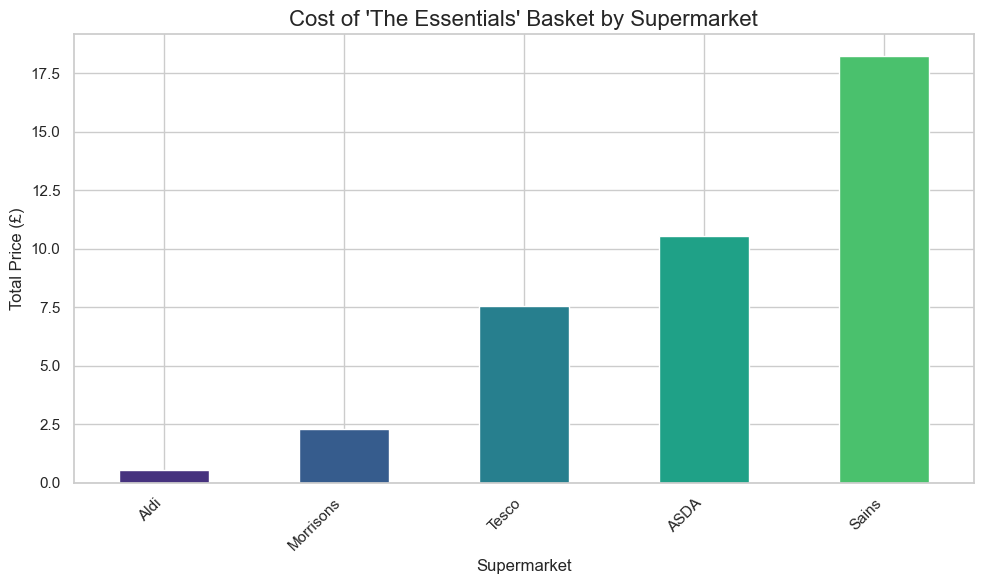

--- Anaysis for 'The Big Brand Shop' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   0.00            0               15      0.000000
Tesco                 12.08            4               15     26.666667
Sains                 17.10            6               15     40.000000
ASDA                  18.95            7               15     46.666667
Morrisons             20.22            7               15     46.666667


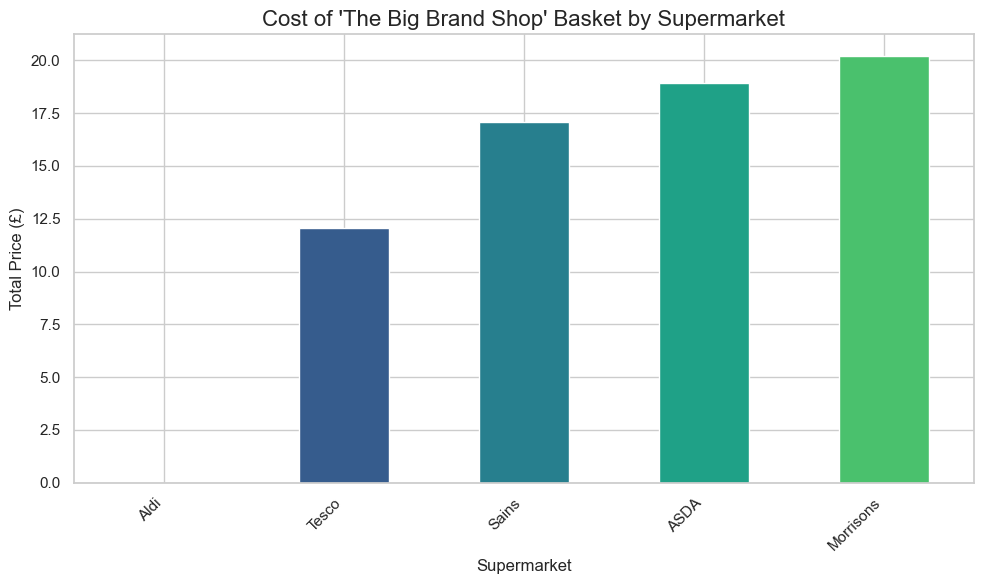

--- Anaysis for 'The Healthy Choice' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Morrisons              5.49            3               15     20.000000
Aldi                   5.78            2               15     13.333333
ASDA                   7.75            3               15     20.000000
Tesco                 22.00            7               15     46.666667
Sains                 25.44           11               15     73.333333


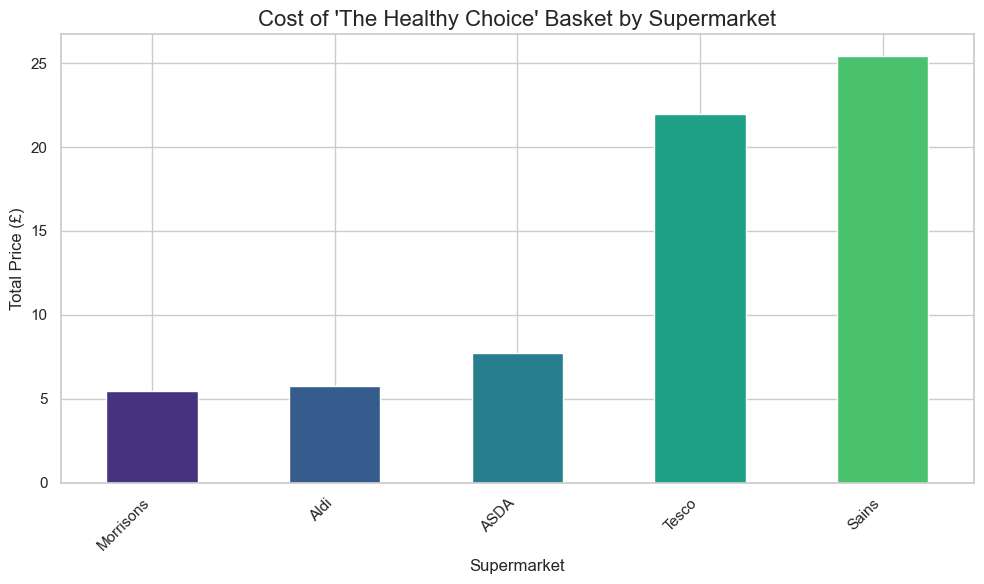

--- Anaysis for 'Food Cupboard' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   1.90            2               20          10.0
Sains                 14.25            7               20          35.0
Morrisons             16.57            6               20          30.0
ASDA                  19.33           10               20          50.0
Tesco                 19.90            8               20          40.0


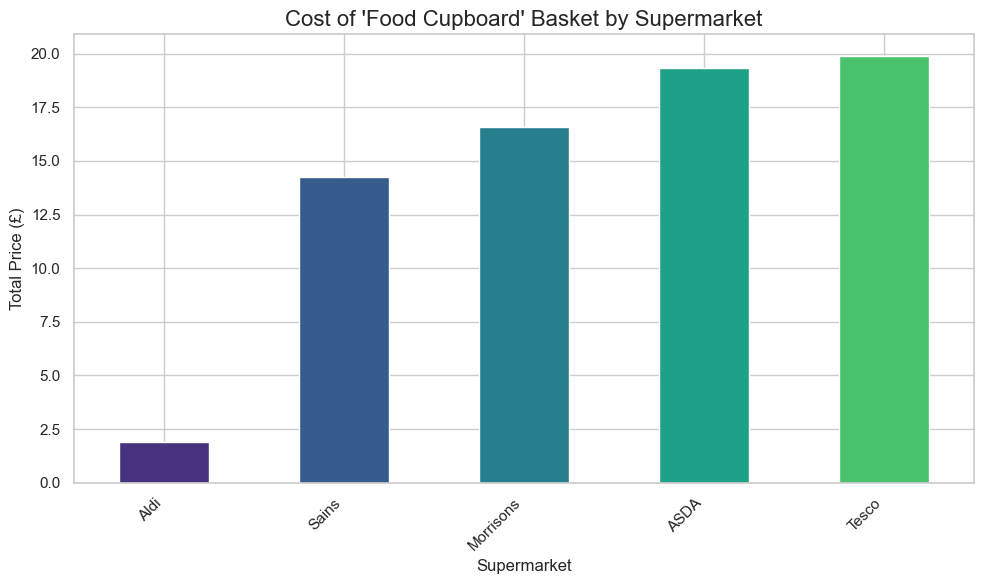

--- Anaysis for 'Health Products' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Tesco                  4.50            1               20           5.0
Aldi                   5.67            5               20          25.0
ASDA                  41.39            6               20          30.0
Morrisons             42.90            5               20          25.0
Sains                 76.00            8               20          40.0


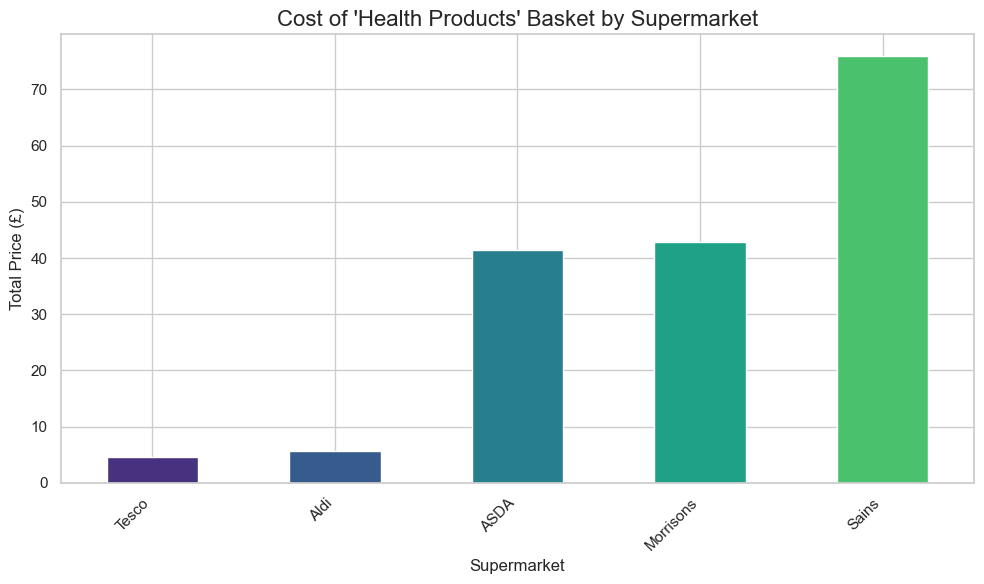

--- Anaysis for 'Fresh Food' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   8.45            5               20          25.0
Tesco                  8.50            3               20          15.0
Morrisons             21.88            7               20          35.0
ASDA                  27.85            6               20          30.0
Sains                 33.85            8               20          40.0


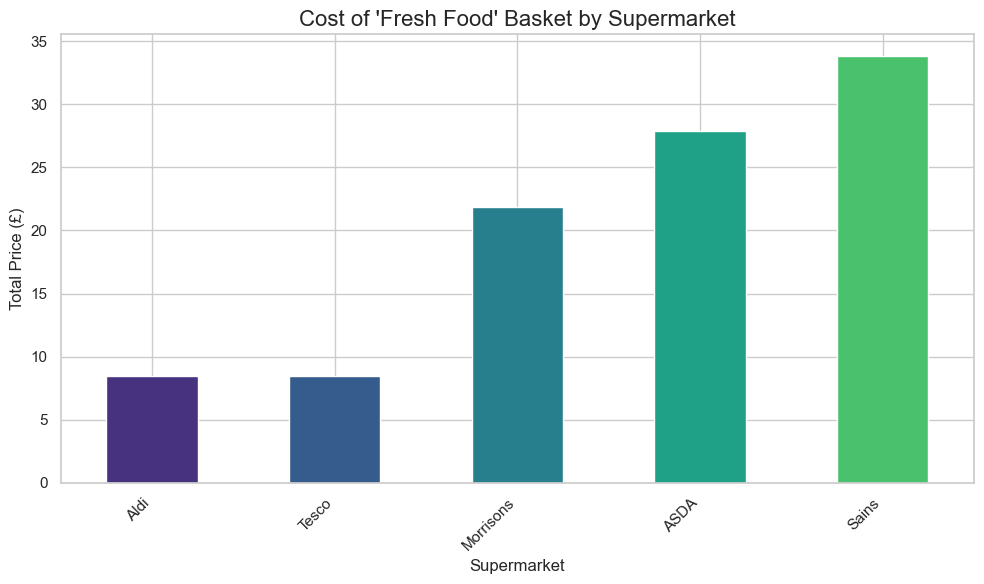

--- Anaysis for 'Drinks' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   5.92            4               20          20.0
Tesco                 37.60            5               20          25.0
Morrisons             50.40            6               20          30.0
ASDA                  60.04            7               20          35.0
Sains                 72.70            7               20          35.0


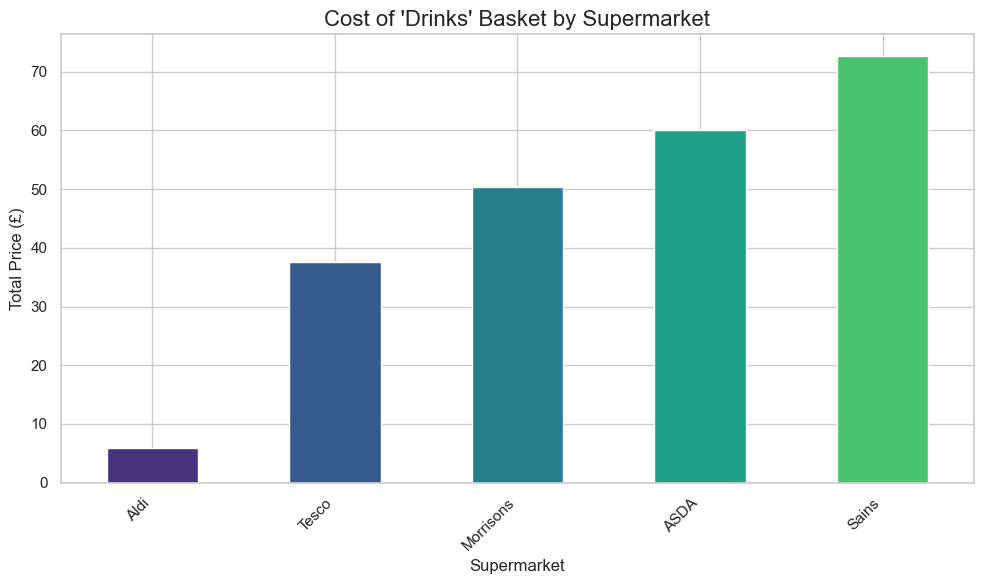

--- Anaysis for 'Household' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Tesco                  9.50            2               20          10.0
Aldi                  10.56            4               20          20.0
Morrisons             11.50            4               20          20.0
Sains                 12.20            4               20          20.0
ASDA                  12.80            5               20          25.0


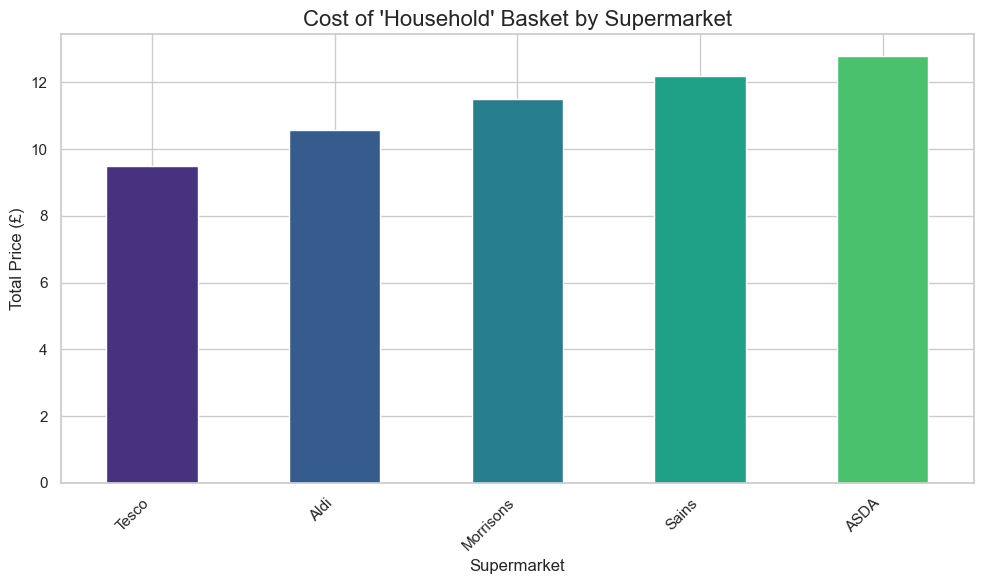

--- Anaysis for 'Free From' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Morrisons              4.80            4               20          20.0
ASDA                  13.30            9               20          45.0
Tesco                 14.20            7               20          35.0
Aldi                  15.72            4               20          20.0
Sains                 25.70           11               20          55.0


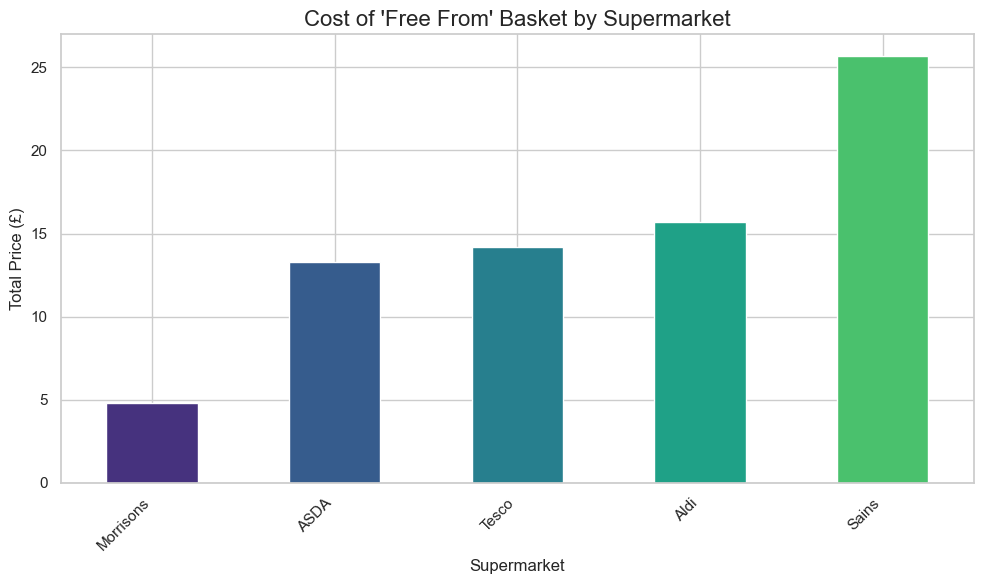

--- Anaysis for 'Frozen Foods' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   5.47            3               20          15.0
Tesco                 11.10            4               20          20.0
Morrisons             17.52            5               20          25.0
Sains                 19.35            6               20          30.0
ASDA                  29.50           10               20          50.0


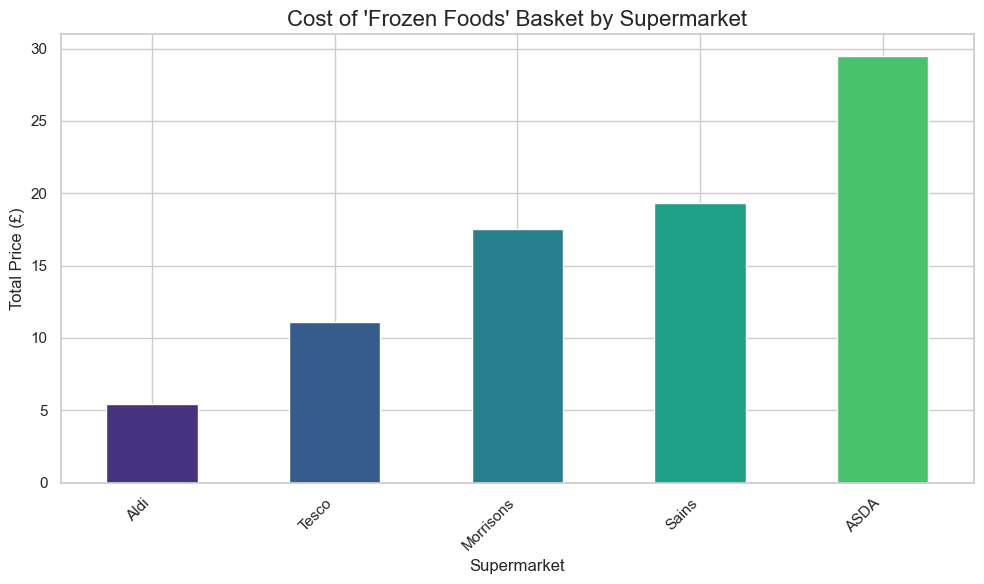

--- Anaysis for 'Pets' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Tesco                  3.30            2               20          10.0
Aldi                   9.73            5               20          25.0
Morrisons             20.98            3               20          15.0
ASDA                  29.29            6               20          30.0
Sains                 52.75            7               20          35.0


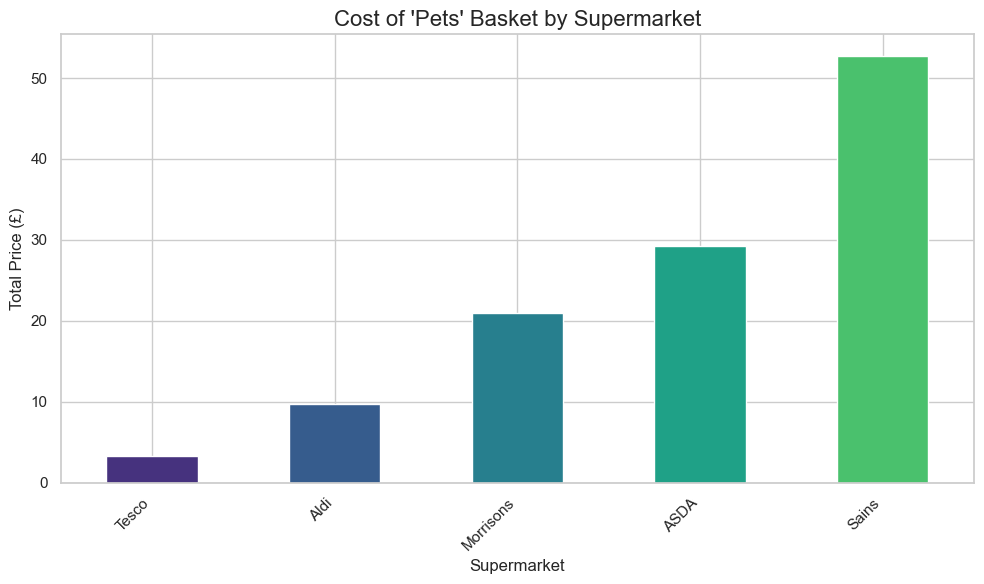

--- Anaysis for 'Baby Products' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Tesco                  8.85            3               20          15.0
Aldi                   9.86            4               20          20.0
Morrisons             26.35            7               20          35.0
Sains                 34.90            9               20          45.0
ASDA                  40.05            9               20          45.0


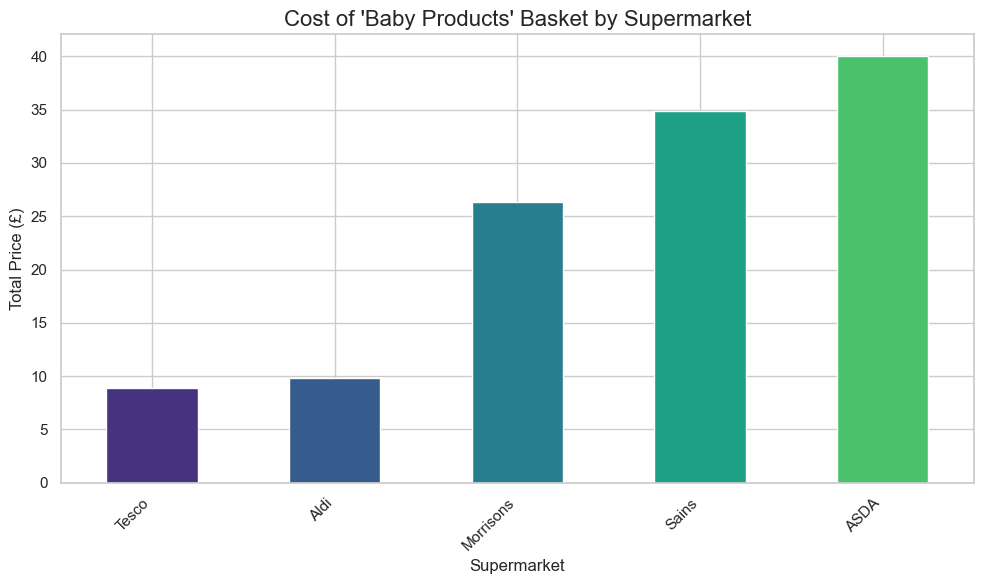

--- Anaysis for 'Bakery' ---
             Total Cost (£)  Items Found  Items in Basket  Coverage (%)
supermarket                                                            
Aldi                   5.35            4               20          20.0
Tesco                  9.70            5               20          25.0
Morrisons             11.14            5               20          25.0
Sains                 22.35            5               20          25.0
ASDA                  31.49            9               20          45.0


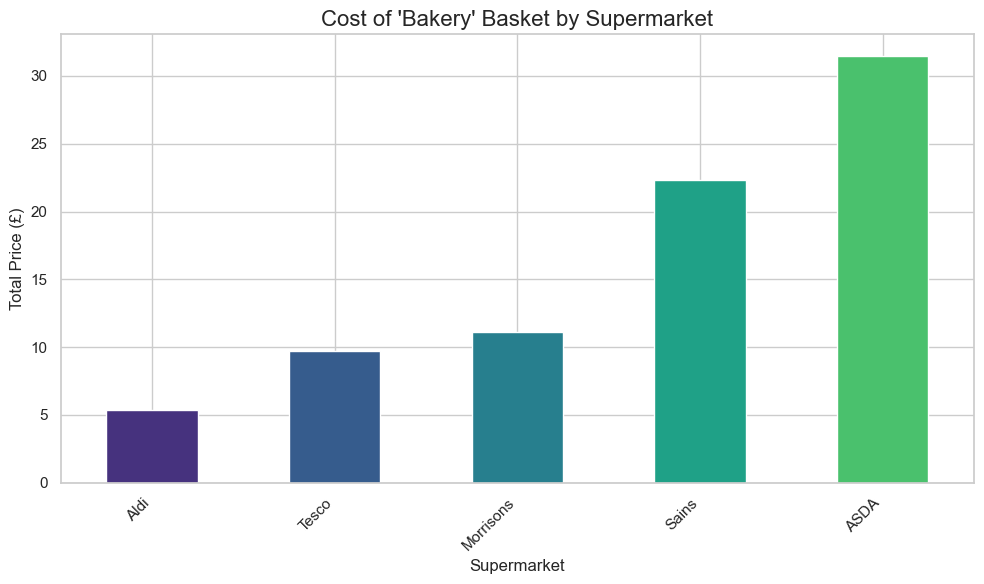

In [8]:
def calculate_basket_cost(pivot_table, basket_items, basket_name):
    """Calculate and visualises the cost of a shopping basket"""

    # FIlter the pivot table to only include items in basket
    basket_df = pivot_table[pivot_table.index.isin(basket_items)]

    # Count how many items from the basket were found at each supermarket
    items_found = basket_df.notna().sum()
    total_items_in_basket = len(basket_items)

    # Cal. total cost 
    basket_cost = basket_df.sum()

    # Create a summary DataFrame
    summary = pd.DataFrame({
        "Total Cost (£)": basket_cost,
        "Items Found": items_found,
        "Items in Basket": total_items_in_basket
    })
    summary["Coverage (%)"] = (summary["Items Found"] / summary["Items in Basket"]) * 100
    summary = summary.sort_values("Total Cost (£)")

    print(f"--- Anaysis for '{basket_name}' ---")
    print(summary)

    plt.figure(figsize=(10, 6))
    summary["Total Cost (£)"].plot(kind="bar", color=sns.color_palette("viridis"))
    plt.title(f"Cost of '{basket_name}' Basket by Supermarket", fontsize=16)
    plt.ylabel("Total Price (£)", fontsize=12)
    plt.xlabel("Supermarket", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return summary

for name, items in baskets.items():
    calculate_basket_cost(price_pivot_canonical, items, name)

## In-Depth Analysis of Basket Results

The biggest takeaway? There’s no straightforward answer to the question, “Which supermarket is cheapest?” It really depends on what we buy—and how much variety matters to us.

1. Aldi’s Pricing Strategy:
    * What we found: Whenever Aldi stocks items in a basket—like Essentials, Food Cupboard, Frozen Foods, or Bakery—it usually has the lowest or second-lowest total cost. For example, in the Essentials basket, Aldi’s prices are just a fraction of what its competitors charge.

    * The catch (coverage): This low price comes with limited choice. Aldi’s coverage is consistently the smallest. For instance, in the Big Brand Shop basket, Aldi had zero of the 15 branded items selected. In Essentials, it only had 1 out of 15 items.

    * What this means: Aldi’s model is clear—they’re not aiming to be a one-stop shop. Instead, they offer a tight, carefully selected range of fast-selling products at very low prices. Shopping at Aldi can save money, but we might have to visit another store to find everything on the list, especially if we want specific brands.

2. The Big Four: Different Strategies, Different Strengths
    * Sainsbury’s:
    Sainsbury’s is often the most expensive or second-most expensive across most baskets (like Essentials, Healthy Choice, Health Products), but it usually has the highest product coverage. For example, in the Healthy Choice basket, it covered 73% of items, compared to Aldi’s 13%.
    Takeaway: Sainsbury’s targets shoppers who value variety, choice (especially in health and “free-from” products), and convenience—and are willing to pay extra for it.

    * ASDA & Tesco:
    These two compete closely. ASDA shines in categories like Food Cupboard and Frozen Foods, offering high coverage and making it a good pick for big family “stock-up” trips. Tesco, meanwhile, surprises with strong pricing in niche areas, being cheapest in Pets and Health Products (although coverage in the latter is low). This could be a deliberate “loss leader” strategy to attract customers.

    * Morrisons:
    Morrisons often undercuts the other Big Four supermarkets. It’s the cheapest in the Essentials basket and even beats Aldi in Healthy Choice and Free From baskets.
    Morrisons seems to position itself as a value-focused alternative that competes head-to-head with Aldi on certain categories while offering a wider range overall.

3. Category-Level Insights:
    * Big Brands: Tesco leads on price among those who stock big brands.

    * Household & Baby Products: Price differences here are closer. Tesco and Aldi are neck and neck, showing fierce competition on these everyday essentials.

    * Specialty Categories (Free From, Healthy Choice): Strategies diverge sharply. Sainsbury’s dominates on choice and variety, while Morrisons surprisingly takes the lead on price—suggesting they’re trying to capture this growing market without charging premium prices.

## Summary
This analysis shows that the “cheapest supermarket” really depends on our priorities—whether you want low prices on a narrow range of products (Aldi), or a wider selection even if it costs more (the Big Four). Each supermarket has carved out a unique strategy to attract different types of shoppers.